## Análise de Causa Raiz com Feature Importance

**Objetivo:** Utilizar modelos de Machine Learning, especificamente a importância de features (Feature Importance) de modelos baseados em árvores, para identificar a causa raiz de defeitos em um processo industrial.

**Contexto:** Em um processo industrial, a ocorrência de defeitos em um produto final pode ser causada por uma infinidade de variáveis de processo. Muitas vezes, a intuição ou análises de correlação simples podem levar a conclusões erradas, gastando tempo e recursos na otimização da variável errada.

**Cenário Fictício:**
Uma linha de produção está enfrentando um aumento na taxa de defeitos de um polímero. A equipe de engenharia suspeita que **variações na temperatura do processo** são a principal causa, pois é a variável mais volátil e historicamente problemática. No entanto, dados de outras variáveis, como a **umidade da matéria-prima**, também são coletados.

Nossa missão é atuar como "detetives de dados" para confirmar ou refutar essa hipótese e encontrar a verdadeira causa raiz.

### Configuração e Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos e Ferramentas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Configurações de visualização
plt.rcParams["figure.figsize"] = (14, 7)

### Geração de Dados Sintéticos

Vamos criar um conjunto de dados que simula nosso cenário. O ponto-chave é que a ocorrência de defeitos (`defeito=1`) será **fortemente influenciada** pela `umidade_materia_prima` e apenas **fracamente influenciada** pela `temperatura_processo` para criar a nossa "pista falsa".

In [2]:
n_samples = 2000
np.random.seed(42)

# Variáveis de processo
temperatura_processo = np.random.normal(150, 5, n_samples)  # A "suspeita"
pressao_reator = np.random.normal(10, 0.5, n_samples)
vibracao_motor = np.random.normal(2, 0.2, n_samples)
vazao_entrada = np.random.normal(100, 10, n_samples)

# A CAUSA RAIZ OCULTA
# Criamos uma correlação sutil entre temperatura e umidade para tornar a análise mais desafiadora
umidade_materia_prima = (
    np.random.normal(3.0, 0.8, n_samples) + (temperatura_processo - 150) * 0.05
)

# Geração do alvo (defeito)
# A probabilidade de defeito aumenta drasticamente com a umidade e um pouco com a temperatura
prob_defeito = 1 / (
    1
    + np.exp(
        -((umidade_materia_prima - 4.5) * 4.0 + (temperatura_processo - 155) * 0.2)
    )
)
defeito = (np.random.rand(n_samples) < prob_defeito).astype(int)

df = pd.DataFrame(
    {
        "temperatura_processo": temperatura_processo,
        "pressao_reator": pressao_reator,
        "vibracao_motor": vibracao_motor,
        "vazao_entrada": vazao_entrada,
        "umidade_materia_prima": umidade_materia_prima,
        "defeito": defeito,
    }
)

print(f"Total de amostras: {len(df)}")
print(f"Taxa de defeitos: {df['defeito'].mean():.2%}")
df.head()

Total de amostras: 2000
Taxa de defeitos: 4.75%


,temperatura_processo,pressao_reator,vibracao_motor,vazao_entrada,umidade_materia_prima,defeito
0,152.483571,9.662411,1.827301,88.859186,3.097758,0
1,149.308678,9.927741,1.993759,93.690692,2.562514,0
2,153.238443,9.603790,2.003603,90.579398,3.024022,0
3,157.615149,9.846019,2.094526,94.520042,3.952543,1
4,148.829233,9.053193,1.726628,97.858497,3.963747,0


### Análise Exploratória de Dados (EDA) - A Pista Falsa

Um analista poderia começar plotando a distribuição da principal suspeita (`temperatura_processo`) para os casos com e sem defeito.

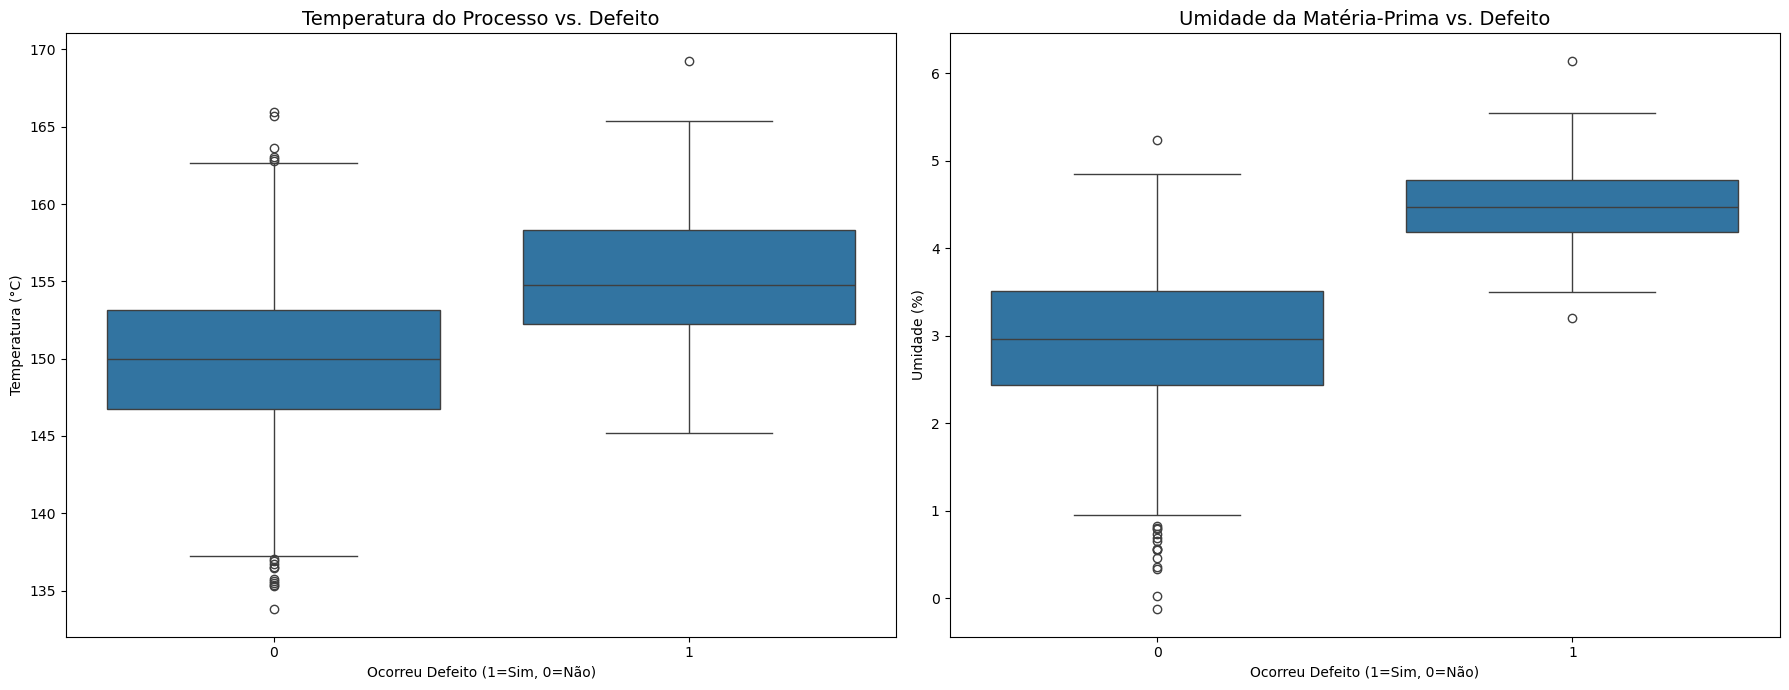

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# Análise da 'pista falsa'
sns.boxplot(x="defeito", y="temperatura_processo", data=df, ax=axs[0])
axs[0].set_title("Temperatura do Processo versus Defeito", fontsize=14)
axs[0].set_xlabel("Ocorreu Defeito (1=Sim, 0=Não)")
axs[0].set_ylabel("Temperatura (°C)")

# Análise da 'causa raiz'
sns.boxplot(x="defeito", y="umidade_materia_prima", data=df, ax=axs[1])
axs[1].set_title("Umidade da Matéria-Prima versus Defeito", fontsize=14)
axs[1].set_xlabel("Ocorreu Defeito (1=Sim, 0=Não)")
axs[1].set_ylabel("Umidade (%)")

plt.tight_layout()

**Interpretação da EDA:**

- O gráfico da esquerda mostra uma ligeira diferença na mediana da temperatura para os casos com defeito. Isso poderia levar a equipe a confirmar sua suspeita e focar em controlar a temperatura.
- No entanto, o gráfico da direita mostra uma separação **muito mais clara e drástica**. Os casos com defeito estão quase todos concentrados em níveis mais altos de umidade. Isso já é um forte indício de que a umidade é uma variável mais importante, mas vamos provar isso com Machine Learning.

### Modelagem para Análise de Causa Raiz

Vamos treinar um modelo de classificação para prever se um defeito ocorrerá com base nas variáveis de processo. O objetivo aqui não é ter um modelo perfeito para previsões futuras, mas sim um modelo que **aprenda as relações** entre as entradas e a saída, para que possamos extrair dele a importância de cada variável.

In [4]:
# Definindo features (X) e alvo (y)
y = df["defeito"]
X = df.drop("defeito", axis=1)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

#### 1 Modelo Intuitivo: Árvore de Decisão

Uma única árvore de decisão é ótima para visualização. As variáveis que aparecem no topo da árvore são as mais importantes para separar os dados.

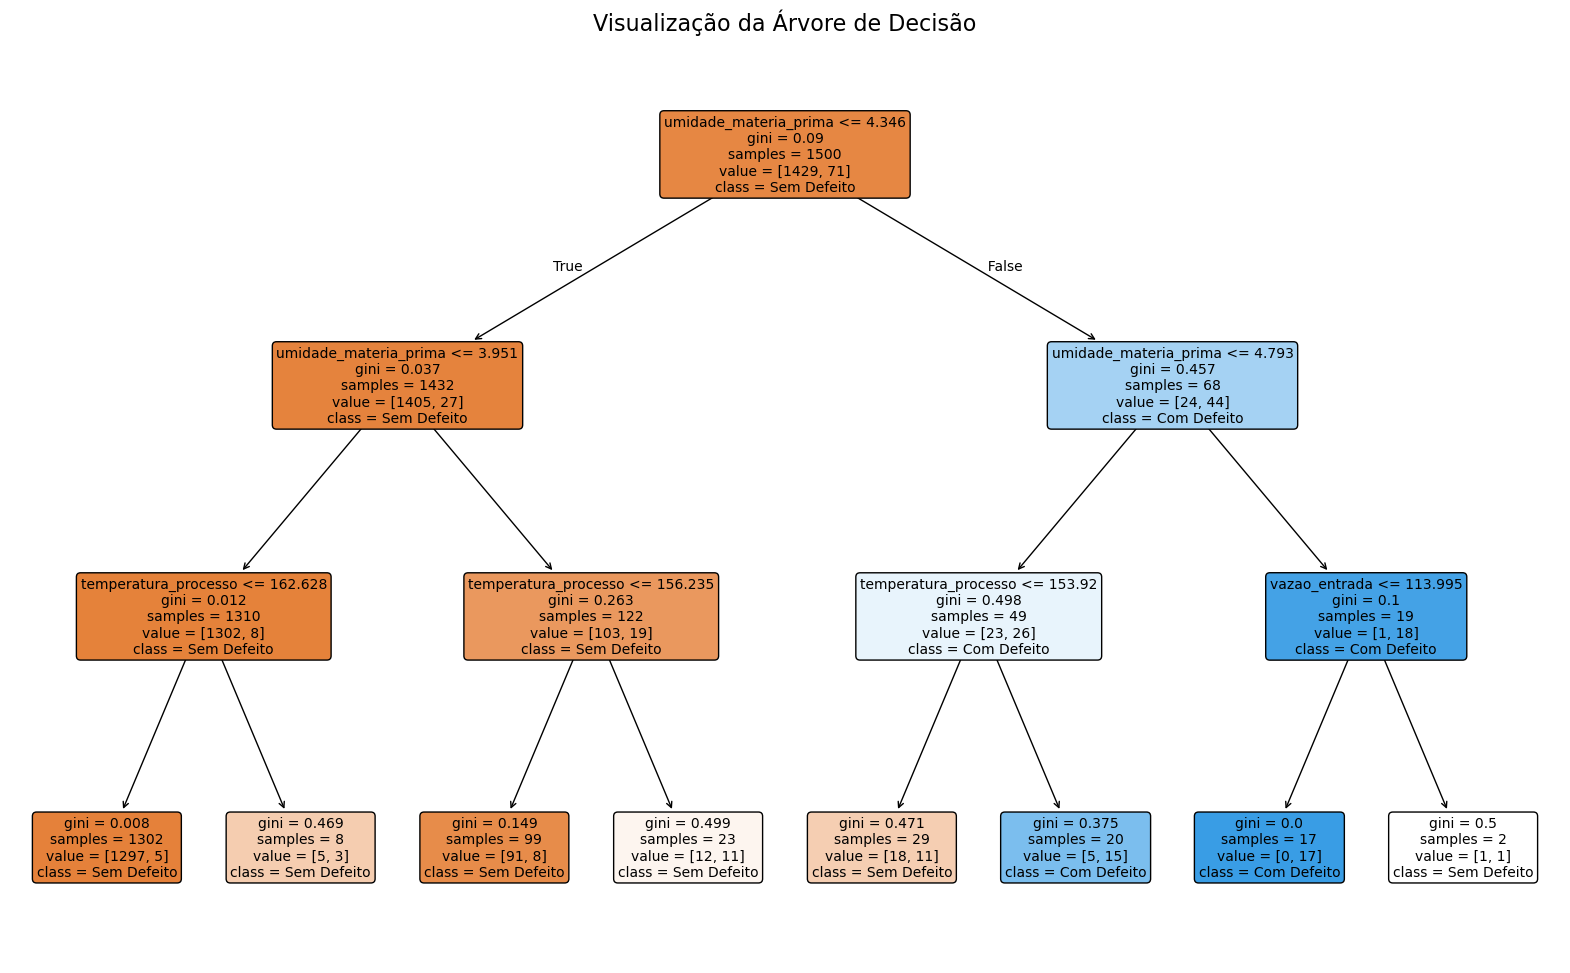

In [5]:
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

plt.figure(figsize=(20, 12))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=["Sem Defeito", "Com Defeito"],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Visualização da Árvore de Decisão", fontsize=16)
plt.show()

**Análise da Árvore:** Observe a primeira divisão (o nó no topo). A árvore escolheu a `umidade_materia_prima` como o fator de decisão mais importante para separar os casos com e sem defeito. Isso já é uma evidência fortíssima contra a hipótese da temperatura.

#### 2 Modelo Robusto: Random Forest

Um Random Forest é um conjunto de muitas árvores de decisão. Ele é mais robusto e nos fornece uma medida de importância de features mais estável, calculada sobre todas as árvores.

Relatório de Classificação do Modelo (para confirmar que ele aprendeu bem):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       476
           1       0.83      0.42      0.56        24

    accuracy                           0.97       500
   macro avg       0.90      0.71      0.77       500
weighted avg       0.96      0.97      0.96       500



/tmp/ipykernel_37305/2468514243.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feature_importances, palette="viridis")


Text(0, 0.5, 'Variável de Processo')

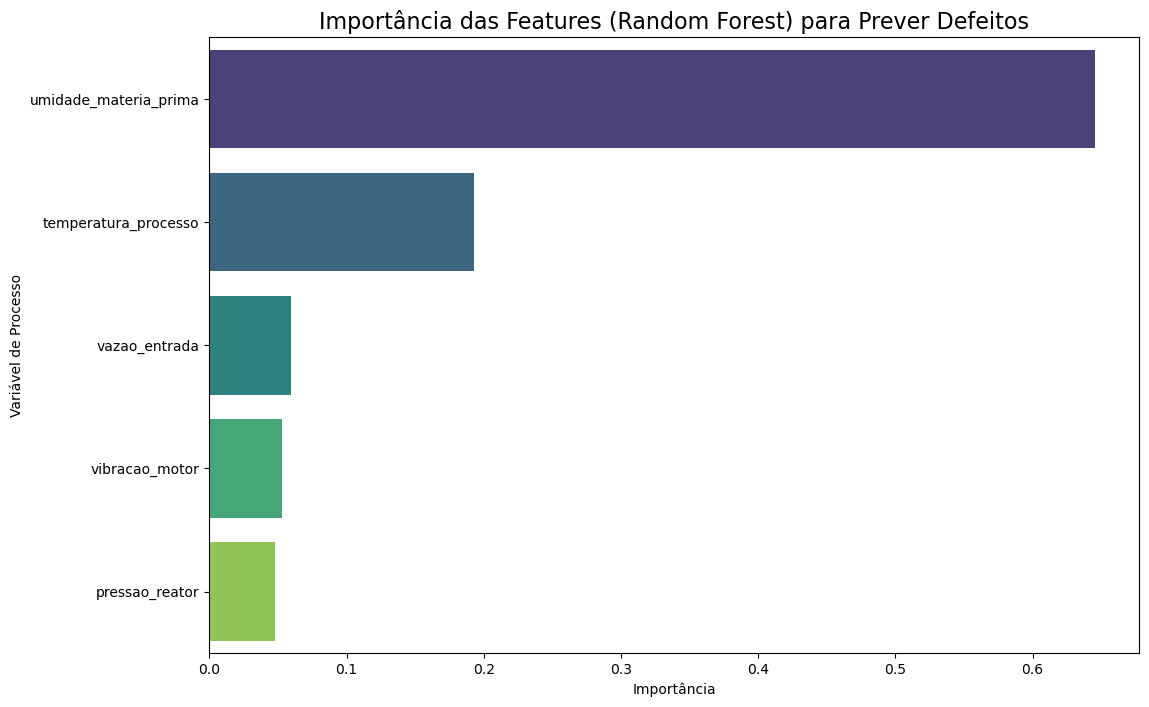

In [6]:
rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)
rf_model.fit(X_train, y_train)

print("Relatório de Classificação do Modelo (para confirmar que ele aprendeu bem):")
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Extraindo e plotando a importância das features
feature_importances = pd.DataFrame(
    {"feature": X_train.columns, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importances, palette="viridis")
plt.title("Importância das Features (Random Forest) para Prever Defeitos", fontsize=16)
plt.xlabel("Importância")
plt.ylabel("Variável de Processo")

### Conclusão e Ações de Melhoria

**Diagnóstico Final:**

O resultado da análise de importância de features é inequívoco. A **`umidade_materia_prima`** é, de longe, a variável mais impactante na ocorrência de defeitos, com uma importância várias vezes maior que a da `temperatura_processo`.

A suspeita inicial da equipe de engenharia estava incorreta. Embora a temperatura possa ter alguma influência (ela aparece com uma importância baixa, mas não nula), focar os esforços de otimização nela traria pouco ou nenhum resultado na redução de defeitos. O modelo de Machine Learning atuou como um árbitro imparcial, apontando a verdadeira causa raiz com base nos dados históricos.

**Próximos Passos e Ações Recomendadas:**

Com essa descoberta, a equipe de engenharia pode agora tomar ações direcionadas e eficazes:
1.  **Investigar a Fonte da Variação:** Por que a umidade da matéria-prima está variando tanto? O problema está no fornecedor? Nas condições de armazenamento (silos, armazéns)?
2.  **Implementar Medição e Controle:** Instalar sensores de umidade na entrada do processo para monitorar esta variável em tempo real.
3.  **Definir Limites de Especificação:** Estabelecer limites de controle muito mais rígidos para a umidade da matéria-prima recebida. Lotes fora da especificação devem ser rejeitados ou tratados (secados) antes do uso.
4.  **Ajustar Parâmetros (se necessário):** Explorar se pequenos ajustes em outras variáveis (como a própria temperatura) podem compensar variações menores na umidade, tornando o processo mais robusto.